# Classification of Good and Bad customers

In [24]:
import pandas as pd
import category_encoders as ce
import math
import numpy as np
import random
import logging
import numbers
import pickle

from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, tree, svm
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Importing German Data

In [2]:
data = pd.read_csv(r"C:\\Users\\DELL\\Downloads\\german.data",delimiter=' ', header=None)

In [3]:
data.columns = ['Checking Account', 'Duration', 'Credit History', 'Purpose', 'Credit Amount', 'Savings Account', 'Employment Length', 'Installment Rate', 'Personal Status and Sex', 'Other Debtors', 'Residence Since', 'Property', 'Age', 'Other Installments', 'Housing', 'Number of Credits at this bank', 'Job', 'Number of People Liable', 'Telephone', 'Foreign Worker', 'Good/Bad']

#Converting to 0-1 classification from 1-2
data['Good/Bad']=data['Good/Bad']-1

data['Duration']= (data['Duration']/10.0).astype(int)

data['Age']= (data['Age']/15.0).astype(int)

In [4]:
df = data

df = df.drop(['Purpose', 'Employment Length', 'Installment Rate', 'Residence Since', 'Other Installments', 'Number of Credits at this bank','Job', 'Number of People Liable', 'Telephone',  ], axis=1)

# Feature encoding 

In [5]:
encoder= ce.OrdinalEncoder(cols=['Checking Account'],return_df=True,
                           mapping=[{'col':'Checking Account',
'mapping':{'A11':0,'A12':1,'A13':2,'A14':3}}])

df_train_transformed = encoder.fit_transform(df)

In [6]:
encoder= ce.OrdinalEncoder(cols=['Credit History'],return_df=True,
                           mapping=[{'col':'Credit History',
'mapping':{'A30':0,'A31':1,'A32':2,'A33':3, 'A34':4}}])

df_train_transformed = encoder.fit_transform(df_train_transformed)

In [7]:
encoder= ce.OrdinalEncoder(cols=['Savings Account'],return_df=True,
                           mapping=[{'col':'Savings Account',
'mapping':{'A61':0,'A62':1,'A63':2,'A64':3, 'A65':4}}])

df_train_transformed = encoder.fit_transform(df_train_transformed)

In [8]:
encoder = ce.OneHotEncoder(cols='Personal Status and Sex',handle_unknown='return_nan',return_df=True,use_cat_names=True)

df_train_transformed = encoder.fit_transform(df_train_transformed)

dump(encoder, 'personal_status_and_sex.joblib')

['personal_status_and_sex.joblib']

In [9]:
encoder = ce.OneHotEncoder(cols='Other Debtors',handle_unknown='return_nan',return_df=True,use_cat_names=True)

df_train_transformed = encoder.fit_transform(df_train_transformed)

dump(encoder, 'other_debtors.joblib')

['other_debtors.joblib']

In [10]:
encoder= ce.OrdinalEncoder(cols=['Property'],return_df=True,
                           mapping=[{'col':'Property',
'mapping':{'A121':0,'A122':1,'A123':2,'A124':3}}])

df_train_transformed = encoder.fit_transform(df_train_transformed)

In [11]:
encoder= ce.OrdinalEncoder(cols=['Housing'],return_df=True,
                           mapping=[{'col':'Housing',
'mapping':{'A152':0,'A151':1,'A153':2}}])

df_train_transformed = encoder.fit_transform(df_train_transformed)

In [12]:
encoder= ce.OrdinalEncoder(cols=['Foreign Worker'],return_df=True,
                           mapping=[{'col':'Foreign Worker',
'mapping':{'A201':0,'A202':1}}])

df_train_transformed = encoder.fit_transform(df_train_transformed)

# Train-Test Split

In [13]:
X = df_train_transformed.iloc[:, :-1].values
y = df_train_transformed.iloc[:, -1].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Standard scaling

In [15]:
sc = StandardScaler()

X_train[:, :] = sc.fit_transform(X_train[:, :])
X_test[:, :] = sc.transform(X_test[:, :])

dump(sc, 'standard_scaler.joblib')

['standard_scaler.joblib']

# Oversampling for imbalanced data using SMOTE

In [16]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()

X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

# Implementation of Classifier PyCOBRA

In [17]:

logger = logging.getLogger('pycobra.classifiercobra')


class ClassifierCobra(BaseEstimator):
    """
    Classification algorithm as introduced by
    Mojirsheibani [1999] Combining Classifiers via Discretization,
    Journal of the American Statistical Association.
    Parameters
    ----------
    random_state: integer or a numpy.random.RandomState object.
        Set the state of the random number generator to pass on to shuffle and loading machines, to ensure
        reproducibility of your experiments, for example.
    Attributes
    ----------
    machines: A dictionary which maps machine names to the machine objects.
            The machine object must have a predict method for it to be used during aggregation.
    machine_predictions: A dictionary which maps machine name to it's predictions over X_l
            This value is used to determine which points from y_l are used to aggregate.
    """
    def __init__(self, random_state=None, machine_list='basic'):
        self.random_state = random_state
        self.machine_list = machine_list

    def fit(self, X, y, default=True, X_k=None, X_l=None, y_k=None, y_l=None):
        """
        Parameters
        ----------
        X: array-like, [n_samples, n_features]
            Training data which will be used to create ClassifierCobra.
        y: array-like [n_samples]
            Training labels for classification.
        default: bool, optional
            If set as true then sets up COBRA with default machines and splitting.
        X_k : shape = [n_samples, n_features]
            Training data which is used to train the machines loaded into COBRA.
        y_k : array-like, shape = [n_samples]
            Target values used to train the machines loaded into COBRA.
        X_l : shape = [n_samples, n_features]
            Training data which is used during the aggregation of COBRA.
        y_l : array-like, shape = [n_samples]
            Target values which are actually used in the aggregation of COBRA.
        """

        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.X_k_ = X_k
        self.X_l_ = X_l
        self.y_k_ = y_k
        self.y_l_ = y_l
        self.estimators_ = {}

        # try block to pass scikit-learn estimator check.
        try:
            # set-up COBRA with default machines
            if default:
                self.split_data()
                self.load_default(machine_list=self.machine_list)
                self.load_machine_predictions()
        except ValueError:
            return self

        return self 


    def pred(self, X, M, info=False):
        """
        Performs the CLassififerCobra aggregation scheme, used in predict method.
        Parameters
        ----------
        X: array-like, [n_features]
        M: int, optional
            M refers to the number of machines the prediction must be close to to be considered during aggregation.
        info: boolean, optional
            If info is true the list of points selected in the aggregation is returned.
        Returns
        -------
        result: prediction
        """

        # dictionary mapping machine to points selected
        select = {}
        for machine in self.estimators_:
            # machine prediction
            file = "Model_" + machine + ".sav"
            model = pickle.load(open(file,'rb'))
            label = model.predict(X)
            select[machine] = set()
            # iterating from l to n
            # replace with numpy iteration
            for count in range(0, len(self.X_l_)):
                if self.machine_predictions_[machine][count] == label:
                    select[machine].add(count)

        points = []
        # count is the indice number.
        for count in range(0, len(self.X_l_)):
            # row check is number of machines which picked up a particular point
            row_check = 0
            for machine in select:
                if count in select[machine]:
                    row_check += 1
            if row_check == M:
                points.append(count)

        # if no points are selected, return 0
        if len(points) == 0:
            if info:
                logger.info("No points were selected, prediction is 0")
                return (0, 0)
            logger.info("No points were selected, prediction is 0")
            return 0

        # aggregate
        classes = {}
        for label in np.unique(self.y_l_):
            classes[label] = 0

        for point in points:
            classes[self.y_l_[point]] += 1

        result = int(max(classes, key=classes.get))
        if info:
            return result, points
        return result


    def predict(self, X, M=None, info=False):
        """
        Performs the ClassifierCobra aggregation scheme, calls pred.
        ClassifierCobra performs a majority vote among all points which are retained by the COBRA procedure.
        Parameters
        ----------
        X: array-like, [n_features]
        M: int, optional
            M refers to the number of machines the prediction must be close to to be considered during aggregation.
        info: boolean, optional
            If info is true the list of points selected in the aggregation is returned.
        Returns
        -------
        result: prediction
        """
        X = check_array(X)

        if M is None:
            M = len(self.estimators_)
        if X.ndim == 1:
            return self.pred(X.reshape(1, -1), M=M)

        result = np.zeros(len(X))
        avg_points = 0
        index = 0
        for vector in X:
            if info:
                result[index], points = self.pred(vector.reshape(1, -1), M=M, info=info)
                avg_points += len(points)
            else:
                result[index] = self.pred(vector.reshape(1, -1), M=M)
            index += 1
        
        if info:
            avg_points = avg_points / len(X_array)
            return result, avg_points
        
        return result


    def predict_proba(self, X, kernel=None, metric=None, bandwidth=1, **kwargs): 
        """
        Performs the ClassifierCobra aggregation scheme and calculates probability of a point being in a particular class.
        ClassifierCobra performs a majority vote among all points which are retained by the COBRA procedure.
        
        NOTE: this method is to visualise boundaries.
        The current method is just the mean of the consituent machines, as the concept of that kind of predicted probability
        doesn't exist (yet) for classifier cobra.
        Parameters
        ----------
        X: array-like, [n_features]
        """

        probs = []
        for machine in self.estimators_:
            try:
                probs.append(self.estimators_[machine].predict_proba(X))
            except AttributeError:
                continue
        prob = np.mean(probs, axis=0)
        return prob


    def split_data(self, k=None, l=None, shuffle_data=True):
        """
        Split the data into different parts for training machines and for aggregation.
        Parameters
        ----------
        k : int, optional
            k is the number of points used to train the machines.
            Those are the first k points of the data provided.
        l: int, optional
            l is the number of points used to form the ClassifierCobra aggregate.
        shuffle: bool, optional
            Boolean value to decide to shuffle the data before splitting.
        Returns
        -------
        self : returns an instance of self.
        """

        if shuffle_data:
            self.X_, self.y_ = shuffle(self.X_, self.y_, random_state=self.random_state)

        if k is None and l is None:
            k = int(len(self.X_) / 2)
            l = int(len(self.X_))

        if k is not None and l is None:
            l = len(self.X_) - k

        if l is not None and k is None:
            k = len(self.X_) - l

        self.X_k_ = self.X_[:k]
        self.X_l_ = self.X_[k:l]
        self.y_k_ = self.y_[:k]
        self.y_l_ = self.y_[k:l]

        return self


    def load_default(self, machine_list='basic'):
        """
        Loads 4 different scikit-learn regressors by default. The advanced list adds more machines. 
        As of current release SGD algorithm is not included in the advanced list.
        Parameters
        ----------
        machine_list: optional, list of strings
            List of default machine names to be loaded.
        Returns
        -------
        self : returns an instance of self.
        """
        if machine_list == 'basic':
            machine_list = ['naive_bayes', 'tree', 'knn', 'svm', 'logreg']
        if machine_list == 'advanced':
            machine_list = ['tree', 'knn', 'svm', 'logreg', 'naive_bayes', 'lda', 'neural_network']

        for machine in machine_list:
            try:
                if machine == 'svm':
                    self.estimators_['svm'] = svm.SVC().fit(self.X_k_, self.y_k_)
                    pickle.dump(self.estimators_['svm'], open('Model_svm.sav','wb'))
                if machine == 'knn':
                    self.estimators_['knn'] = neighbors.KNeighborsClassifier().fit(self.X_k_, self.y_k_)
                    pickle.dump(self.estimators_['knn'], open('Model_knn.sav','wb'))
                if machine == 'tree':
                    self.estimators_['tree'] = tree.DecisionTreeClassifier().fit(self.X_k_, self.y_k_)
                    pickle.dump(self.estimators_['tree'], open('Model_tree.sav','wb'))
                if machine == 'logreg':
                    self.estimators_['logreg'] = LogisticRegression(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                    pickle.dump(self.estimators_['logreg'], open('Model_logreg.sav','wb'))
                if machine == 'naive_bayes':
                    self.estimators_['naive_bayes'] = GaussianNB().fit(self.X_k_, self.y_k_)
                    pickle.dump(self.estimators_['naive_bayes'], open('Model_naive_bayes.sav','wb'))
                if machine == 'lda':
                    self.estimators_['lda'] = LinearDiscriminantAnalysis().fit(self.X_k_, self.y_k_)
                    pickle.dump(self.estimators_['lda'], open('Model_lda.sav','wb'))
                if machine == 'neural_network':
                    self.estimators_['neural_network'] = MLPClassifier(random_state=self.random_state).fit(self.X_k_, self.y_k_)
                    pickle.dump(self.estimators_['neural_network'], open('Model_neural_network.sav','wb'))
            except ValueError:
                continue

        return self


    def load_machine(self, machine_name, machine):
        """
        Adds a machine to be used during the aggregation strategy.
        The machine object must have been trained using X_k and y_k, and must have a 'predict()' method.
        After the machine is loaded, for it to be used during aggregation, load_machine_predictions must be run.
        Parameters
        ----------
        machine_name : string
            Name of the machine you are loading
        machine: machine/regressor object
            The regressor machine object which is mapped to the machine_name
        Returns
        -------
        self : returns an instance of self.
        """


        return self


    def load_machine_predictions(self, predictions=None):
        """
        Stores the trained machines' predicitons on D_l in a dictionary, to be used for predictions.
        Should be run after all the machines to be used for aggregation is loaded.
        Parameters
        ----------
        predictions: dictionary, optional
            A pre-existing machine:predictions dictionary can also be loaded.
        Returns
        -------
        self : returns an instance of self.
        """
        self.machine_predictions_ = {}
        if predictions is None:
            for machine in self.estimators_:
                self.machine_predictions_[machine] = self.estimators_[machine].predict(self.X_l_)

        return self


    def load_machine_proba_predictions(self, predictions=None):
        """
        Stores the trained machines' predicitons on D_l in a dictionary, to be used for predictions.
        Should be run after all the machines to be used for aggregation is loaded.
        Parameters
        ----------
        predictions: dictionary, optional
            A pre-existing machine:predictions dictionary can also be loaded.
        Returns
        -------
        self : returns an instance of self.
        """
        self.machine_proba_predictions_ = {}
        if predictions is None:
            for machine in self.estimators_:
                try:
                    self.machine_proba_predictions_[machine] = self.estimators_[machine].predict_proba(self.X_l_)
                except AttributeError:
                    self.machine_proba_predictions_[machine] = self.estimators_[machine].decision_function(self.X_l_)
        return self

In [18]:
obj = ClassifierCobra()

In [19]:
obj.fit(X_train_sm, y_train_sm)

ClassifierCobra()

Saving files for prediction later

In [20]:
dump(obj.X_l_, 'X_l_.joblib')
dump(obj.y_l_, 'y_l_.joblib')
dump(obj.machine_predictions_, 'machine_predictions_.joblib')

['machine_predictions_.joblib']

# Prediction on test set using classifier PyCOBRA

In [21]:
y_pred_cobra = obj.predict(X_test)

In [22]:
cm = confusion_matrix(y_test, y_pred_cobra)
print(cm)
accuracy_score(y_test, y_pred_cobra)

[[109  32]
 [ 20  39]]


0.74

<AxesSubplot:>

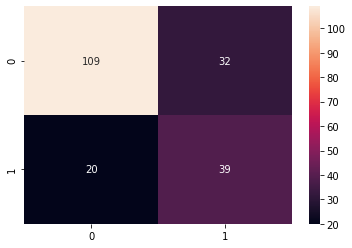

In [27]:
sns.heatmap(confusion_matrix(y_test, y_pred_cobra), annot = True, fmt='g')

In [28]:
print(classification_report(y_test, y_pred_cobra))

              precision    recall  f1-score   support

           0       0.84      0.77      0.81       141
           1       0.55      0.66      0.60        59

    accuracy                           0.74       200
   macro avg       0.70      0.72      0.70       200
weighted avg       0.76      0.74      0.75       200



In [23]:
eff_cost = cm[1][0]*5 + cm[0][1]
eff_cost

132